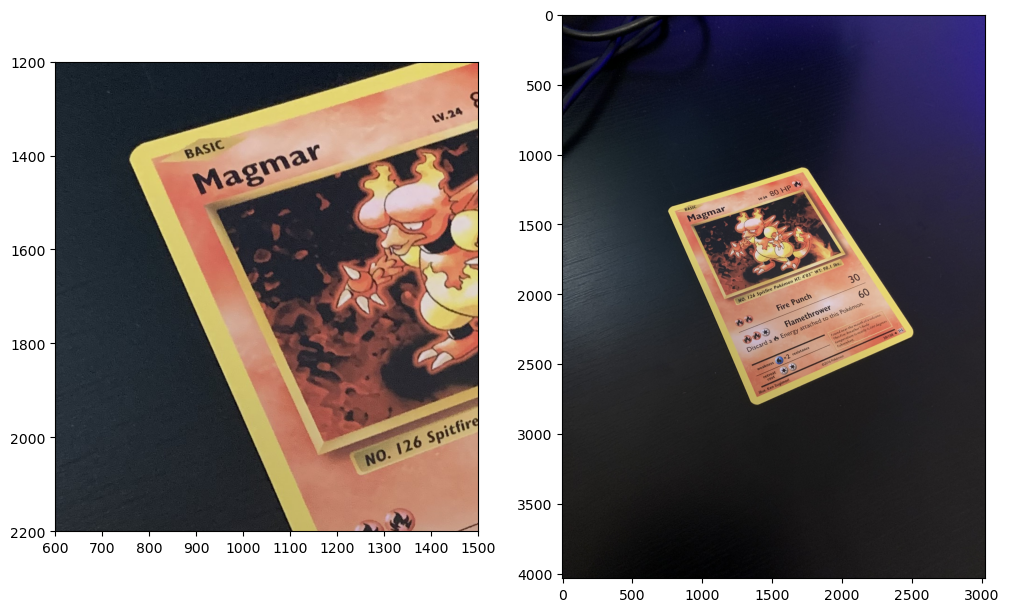

In [527]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the image
image = cv2.imread('test_images/tiltleft2.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.xlim(600, 1500)
plt.ylim(2200, 1200)
plt.subplot(1, 2, 2)
plt.imshow(image_rgb)

(1800.0, 1200.0)

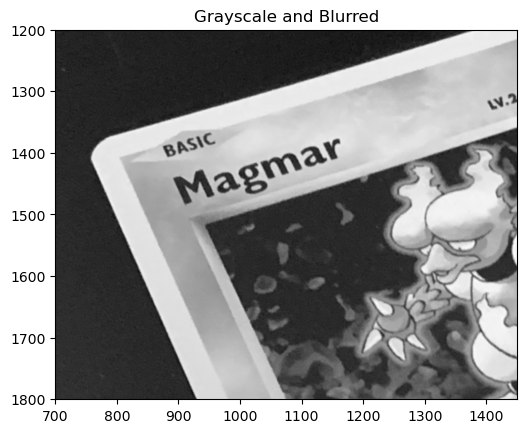

In [528]:
# Step 2: Convert to grayscale and blur
gray = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(src=gray, ksize=(3, 3), sigmaX=0)
plt.title("Grayscale and Blurred")
plt.imshow(blurred, cmap="gray")
plt.xlim(700, 1450)
plt.ylim(1800, 1200)

(1800.0, 1200.0)

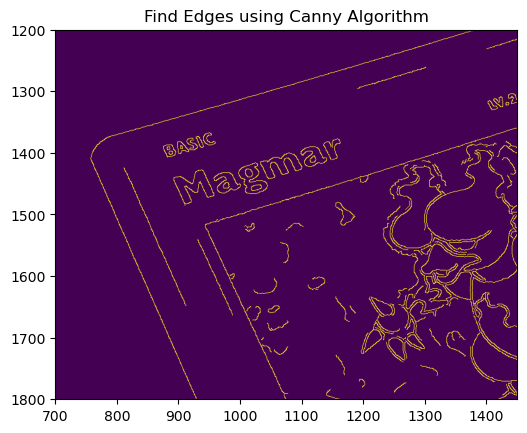

In [529]:
# Step 3a: Edge detection - Canny Algorithm
edges = cv2.Canny(image=blurred, threshold1=100, threshold2=200)
plt.title("Find Edges using Canny Algorithm")
plt.imshow(edges)
plt.xlim(700, 1450)
plt.ylim(1800, 1200)

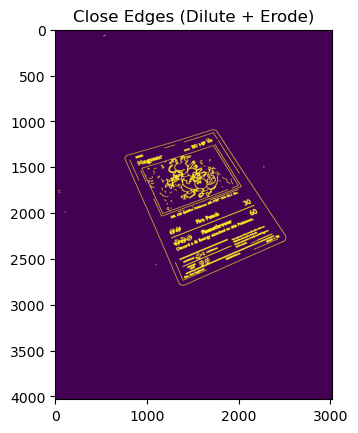

In [530]:
# Step 3b: Edge detection - Dilate and Erode
kernel = np.ones(shape=(5, 5))
dilated = cv2.dilate(src=edges, kernel=kernel, iterations=2)
closed_edges = cv2.erode(src=dilated, kernel=kernel, iterations=1)
plt.title("Close Edges (Dilute + Erode)")
plt.imshow(closed_edges)

(3000.0, 1200.0)

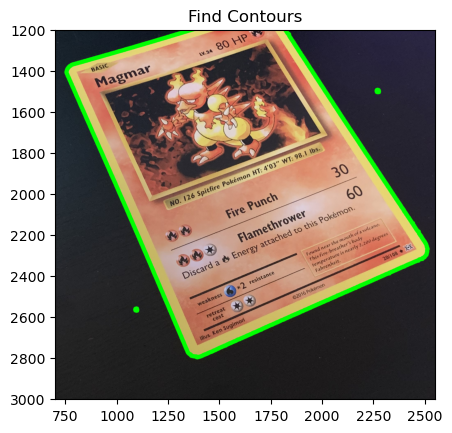

In [531]:
# Step 4a: Contour Processing - Find Contours
contours, _ = cv2.findContours(
    image=closed_edges, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE
)
contour_image = image.copy()
cv2.drawContours(
    image=contour_image, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=20
)
contour_image_rgb = cv2.cvtColor(src=contour_image, code=cv2.COLOR_BGR2RGB)
plt.title("Find Contours")
plt.imshow(contour_image_rgb)
plt.xlim(700, 2550)
plt.ylim(3000, 1200)

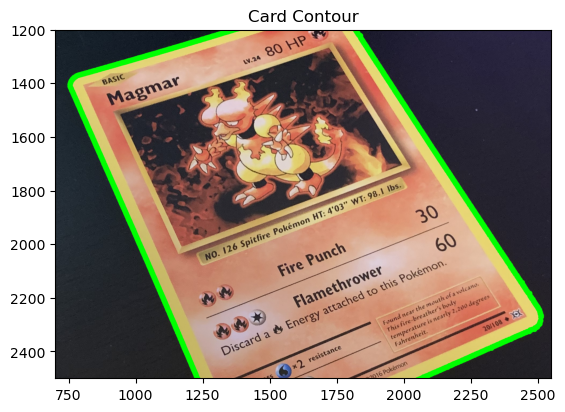

In [532]:
# Step 4b: Contour Processing - Filter Card Contour

best_contour = None
best_approx = None

# Loop through contours to find the largest one with 4 sides
for contour in contours:
    # Approximate the contour
    perimeter = cv2.arcLength(contour, True)
    epsilon = 0.05 * perimeter
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # Check if the approximated contour has 4 vertices
    if len(approx) == 4:
        if best_contour is None or cv2.contourArea(contour) > cv2.contourArea(best_contour):
            best_contour = contour
            best_approx = approx
if best_contour is not None:
    contour_image = image.copy()
    cv2.drawContours(
        image=contour_image, contours=best_contour, contourIdx=-1, color=(0, 255, 0), thickness=20
    )
    contour_image_rgb = cv2.cvtColor(src=contour_image, code=cv2.COLOR_BGR2RGB)
    plt.title("Card Contour")
    plt.imshow(contour_image_rgb)
    plt.xlim(700, 2550)
    plt.ylim(2500, 1200)
else:
    print("No 4 Sided Contour Found")

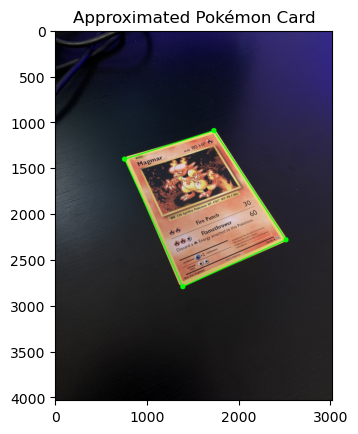

In [533]:
# Step 5: Draw the 4 Sided Card Approximation
if best_contour is not None:
    approx_image = image.copy()
    
    for point in best_approx:
        x, y = point[0]
        cv2.circle(approx_image, (x, y), 3, (0, 255, 0), 50)

    # drawing skewed rectangle
    cv2.drawContours(approx_image, [best_approx], -1, (0, 255, 0), 10)
    
    # Display the image with the contour using Matplotlib
    approx_image_rgb = cv2.cvtColor(approx_image, cv2.COLOR_BGR2RGB)
    plt.imshow(approx_image_rgb)
    plt.title('Approximated Pokémon Card')
    plt.show()

In [534]:
# Step 5: Reorder the corners

# Order needs to be top-left, top-right, bottom-right, bottom-left

corners = np.array(best_approx).reshape(4, 2)

# Calculate the sum of each corner's coordinates along axis 1
coord_sums = corners.sum(axis=1)

# Get the indices that would sort the coordinate sums
sorted_indices = np.argsort(coord_sums)

top_left = corners[sorted_indices[0]]
bottom_right = corners[sorted_indices[3]]

is_titled_right = corners[sorted_indices[1]][1] > corners[sorted_indices[2]][1]
if is_titled_right:
    top_right = corners[sorted_indices[2]]
    bottom_left = corners[sorted_indices[1]]
else:
    top_right = corners[sorted_indices[1]]
    bottom_left = corners[sorted_indices[2]]

ordered_corners = np.array([
    top_left,
    top_right,
    bottom_right,
    bottom_left,
], dtype="float32")

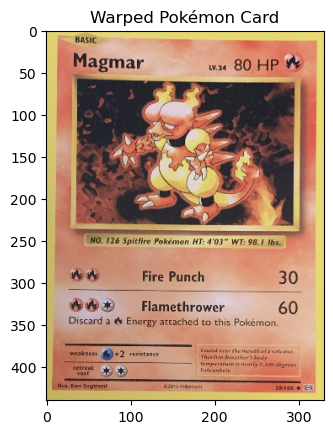

In [535]:
# Step 6: Warp the image to a Rectangle
    
width, height = 330, 440
dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype='float32')

# Get the perspective transform matrix
M = cv2.getPerspectiveTransform(ordered_corners, dst)
warped = cv2.warpPerspective(image, M, (width, height))

# Convert BGR to RGB for Matplotlib
warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

# Display the result using Matplotlib
plt.imshow(warped_rgb)
plt.title('Warped Pokémon Card')
plt.show()

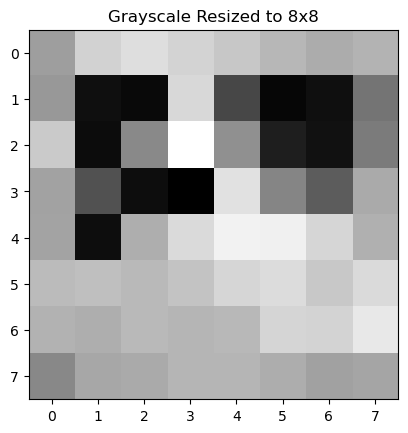

In [536]:
# Step 7 Image Hashing - Convert to Grayscale
gray = cv2.cvtColor(src=warped, code=cv2.COLOR_BGR2GRAY)
HASH_SIZE = 8
gray_resized = cv2.resize(gray, (HASH_SIZE, HASH_SIZE))
plt.imshow(gray_resized, cmap="gray")
plt.title('Grayscale Resized to 8x8')
plt.show()

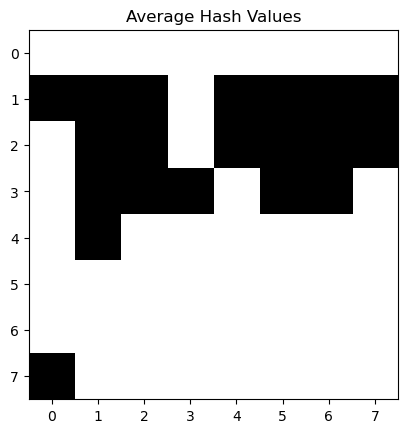

'ff109089bfffff7f'

In [537]:
avg_pixel = np.mean(gray_resized)
diff = gray_resized > avg_pixel
plt.imshow(diff, cmap="gray")
plt.title('Average Hash Values')
plt.show()
hash_str = "".join(["1" if b else "0" for b in diff.flatten()])
hash_str
hex(int(hash_str, 2))[2:].zfill(16)

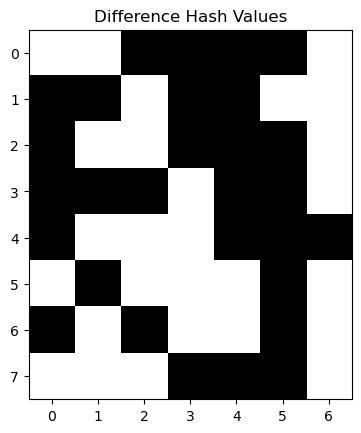

'00c24d88971756f1'

In [538]:
diff = gray_resized[:, 1:] > gray_resized[:, :-1]
plt.imshow(diff, cmap="gray")
plt.title('Difference Hash Values')
plt.show()
hash_str = "".join(["1" if b else "0" for b in diff.flatten()])
hash_str
hex(int(hash_str, 2))[2:].zfill(16)